# Load the dataset
Firstly, I import the dataset related to tourists arrivals to Italy from 1990 to 2019 as as a `pandas` dataframe. Data are extracted from the [European Statistics: Annual Data on Tourism Industries](https://ec.europa.eu/eurostat/web/tourism/data/database).

In [102]:
import pandas as pd

df = pd.read_csv('source/tourist_arrivals.csv')
df.head()

,date,value
0,'2012-01-01',2343290
1,'2012-02-01',10468842
2,'2012-03-01',13908950
3,'2012-04-01',18456089
4,'2012-05-01',20294254


Now I convert the dataset into a time series. This can be done in three steps:
* I convert the `date` column to the datetime type
* I set the `date` column as index of the dataframe
* I assign the `value` column of the dataframe to a new variable, called `ts`.

In [103]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
ts = df['value']
ts

date
2012-01-01     2343290
2012-02-01    10468842
2012-03-01    13908950
2012-04-01    18456089
2012-05-01    20294254
                ...   
2019-05-01    24832942
2019-06-01    34658825
2019-07-01    39123041
2019-08-01    41588218
2019-09-01    30253817
Name: value, Length: 93, dtype: int64

I explore the time series by plotting it. I exploit the `matplotlib` library.

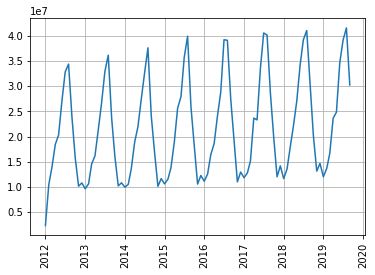

In [104]:
from matplotlib import pyplot as plt

plt.plot(ts, label='prediction seasonal')
plt.grid()
plt.xticks(rotation=90)
plt.show()

I note that the time series presents a seasonality thus a SARIMA model is appropriate. In addition, the time series also presents an increasing trend.

# (p,d,q) Order

Now I split the time series into two parts: train and test sets. Training set will be used to fit the model, while the test set will be use to evalute it.

In [105]:
ts_train = ts[:'2019-03-01']
ts_test = ts['2019-04-01':]

Into another notebook, I have already explained how to calculate the (p,d,q) order of the SARIMA model, thus I set it manually to the discovered values:

In [106]:
d = 1
p = 10
q = 7

# (P,D,Q,M) Order

The (P,D,Q,M) Order refers to the seasonal component of the model for the Auto Regressive parameters, differences, Moving Average parameters, and periodicity:

* D indicates the integration order of the seasonal process (the number of transformation needed to make stationary the time series)
* P indicates the Auto Regressive order for the seasonal component
* Q indicated the Moving Average order for the seasonal component
* M indicates the periodicity, i.e. the number of periods in season, such as 12 for monthly data.

In order to evaluate the seasonal order, we must extract the seasonal component from the time series. For this reason, we exploit the `seasonal_decompose()` function provided by the `statsmodels` library. Among the input parameters, we can specify the decomposition model (additive or multiplicative) and if we want to extrapolate the trend or not. The function returns the trend, the seasonal and the resid components. 

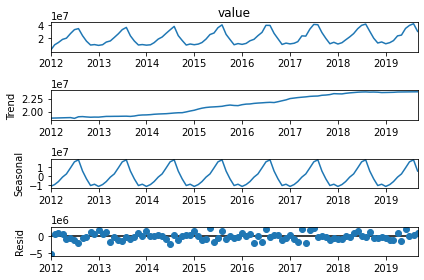

In [107]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ts, model='additive',extrapolate_trend='freq')
result.plot()
plt.show()

## D order
In order to extract D, we have to check whether the seasonal componenet is stationary or not. We define a function, which exploits the Adfuller test to check for stationarity.

In [108]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

Then, we invoke the `check_stationarity()` function on the seasonal component of the time series:

In [109]:
seasonal = result.seasonal
check_stationarity(seasonal)

The series is stationary


The series is stationary, thus we do not need any additional transformation to make it stationary. We can set D = 0.

In [110]:
D = 0

## P order
The value of P can be extracted by looking at the Partial Autocorrelation (PACF) graph of the seasonal component. PACF can be imagined as the correlation between the series and its lag, after excluding the contributions from the
intermediate lags.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


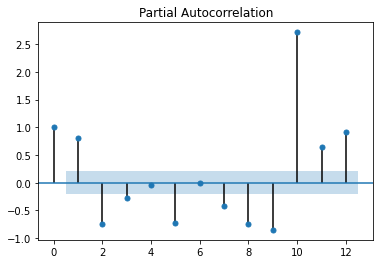

In [111]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(seasonal, lags =12)
plt.show()

In the PACF graph the maximum value out the confidence intervals (in light blue) is 12, thus we can set P = 12

In [112]:
P = 12

## Q Order
The Q order can be calculated from the Autocorrelation (ACF) plot. Autocorrelation is the correlation of a
single time series with a lagged copy of itself.

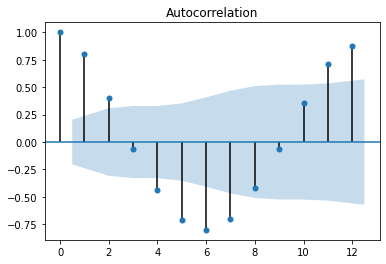

In [113]:
plot_acf(seasonal, lags =12)
plt.show()

From the above graph, we note that the maximum value out the confidence intervals is 8, thus Q = 8.

In [114]:
Q = 8

# Train model
In order to show the difference between a SARIMA model with and without the tuning of the (P,D,Q,M) order, we fit two models, the first without the seasonality order and second with it.

## Fit without the (P,D,Q,M) order
We exploit the `SARIMAX()` class of the `statsmodels` package and we configure it to work only with the (p,d,q) order.

In [115]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(ts_train, order=(p,d,q))
model_fit = model.fit()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting

After fitting, we calculate forecasts for testing data.

In [116]:
n_test = ts_test.shape[0]
ts_pred = model_fit.forecast(steps=n_test)

As evaluation measure, we calculate the Normalised Root Mean Square Error (NRMSE).

In [117]:
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(ts_pred, ts_test)/(np.max(ts_test)-np.min(ts_test))
nrmse

0.0602505102281063

## Fit with the (P,D,Q,M) order
We fit the model by also passing to it the `seasonal_order` parameter. This operation requires more than the previous one.

In [118]:
model_seasonal = SARIMAX(ts_train, order=(p,d,q), seasonal_order=(P,D,Q,12))
model_fit_seasonal = model_seasonal.fit()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimizatio

We calculate forecasts and NRMSE:

In [119]:
ts_pred_seasonal = model_fit_seasonal.forecast(steps=n_test)
nrmse_seasonal = rmse(ts_pred_seasonal, ts_test)/(np.max(ts_test)-np.min(ts_test))
nrmse_seasonal

0.08154124683514104

# Considerations
We note that the model without the seasonal order outperforms the other model, in terms of NRMSE.

Is the (P,D,Q,M) order useless? Indeed it is not.
For short-term predictions, the two models behave almost in the same way. However, for long-term predictions, the model with the (P,D,Q,M) order is more realistic, since it reflects the increasing trend.

To explain this concept, we can calculate a long-term forecasting in both cases:

In [120]:
N = 300
ts_pred = model_fit.forecast(steps=n_test+N)
ts_pred_seasonal = model_fit_seasonal.forecast(steps=n_test+N)

and we can plot the results. We note that there is a big difference between the two models. While the model without the (P,D,Q,M) order tends to decrease over time, the other reflects the increasing trend.

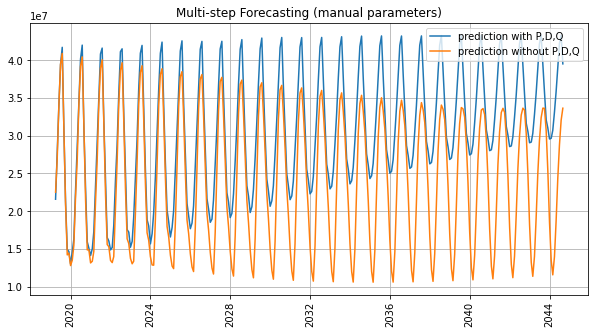

In [122]:
plt.figure(figsize=(10,5))
plt.plot(ts_pred_seasonal, label='prediction with P,D,Q')
plt.plot(ts_pred, label='prediction without P,D,Q')
#plt.plot(ts_test, label='actual')
plt.title('Multi-step Forecasting (manual parameters)')
plt.legend()
plt.grid()
plt.xticks(rotation=90)
plt.show()